# Single TME analysis with Xenium data

## 1. Loading library

In [54]:
# import library
import skny as sk
import stlearn as st
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

Please run the tutorial of "Annotation of tumor contours and distances using Xenium data."

## 2. Reading preprocessed Xenium data

In [51]:
# load preprocessed object
grid = sc.read_h5ad('example_preprocessed.h5ad')
# load table of distance
df_shotest = pd.read_table("example_distance.txt", index_col=0)
# convert str to pd.interval
df_shotest["region"] = pd.cut(
    df_shotest.dropna()["euclidean"], 
    bins=list(range(-15, 16, 3))
)
# attribute the table to object
grid.shortest = df_shotest

In [ ]:
grid

## 3. Converting from grid data to single TME data

In [55]:
# convert
solid = sk.pp.convert_indivisual_solid(grid)

In [56]:
solid.layers["counts"] = solid.X.copy()
sc.pp.normalize_total(solid)
sc.pp.log1p(solid)
sc.pp.pca(solid)
sc.pp.neighbors(solid)
sc.tl.umap(solid)
sc.tl.leiden(solid)

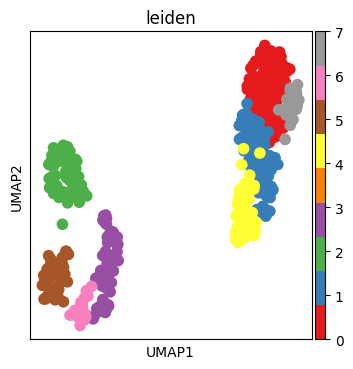

In [61]:
solid.obs["leiden"] = solid.obs["leiden"].astype(float)
fig, ax = plt.subplots(figsize=(4, 4))
cmap = matplotlib.cm.Set1
cmap.N = len(solid.obs["leiden"].unique())
cmap.N = 9
ax = sc.pl.umap(
    solid,
    color=[
        "leiden",
    ],
    wspace=0.4,
    ax=ax, 
    cmap=cmap, )

In [62]:
df_shotest = solid.shortest

df_solid = solid.obs
df_solid = df_solid.reset_index(drop=True)

df_shotest = pd.merge(df_shotest, df_solid, on="solid", how="left")

In [63]:
# save figure
fig, ax = plt.subplots(figsize=(N_COL, N_ROW), dpi=1, tight_layout=True)

image = np.array(df_shotest["leiden"].astype(float).fillna(-1)).reshape(N_ROW, N_COL)
cmap = matplotlib.cm.Set1
cmap.set_bad('black',1.)
cmap.set_under(color='black') 

ax.imshow(
    image, cmap=cmap,
    vmin=0,
    vmax=8,
)
ax.axis('off')
#plt.savefig("cluster.png")

NameError: name 'N_COL' is not defined